## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from pathlib import Path
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.profiler import profile, record_function, ProfilerActivity
from src.model.ITrackerData import TrainITrackerData
from src.model.ITrackerData import TestITrackerData
from src.model.ITrackerModel import ITrackerModel


In [ ]:
dataset_file = Path("/content/drive/MyDrive/Machine Learning System Design/Data/GazeCapture/eye_tracker_train_and_val.npz")

SAVE_DIR = Path("/content/drive/MyDrive/Machine Learning System Design/Data/Weights")
SAVE_BEST_FILE = SAVE_DIR / "best_gazecapture_model.pth"
SAVE_RECENT_FILE = SAVE_DIR / "last_gazecapture_model.pth"

## Exploration

In [ ]:
# Create datasets for training & validation, download if necessary
training_set = TrainITrackerData(str(dataset_file))
validation_set = TestITrackerData(str(dataset_file))

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

NameError: ignored

In [ ]:
dataiter = iter(training_loader)
face, eye_left, eye_right, face_mask, y = next(dataiter)


In [ ]:
dataiter = iter(training_loader)
face, eye_left, eye_right, face_mask, y = next(dataiter)

# Create a grid from the images and show them
plt.imshow(np.transpose(face.numpy()[0], (1, 2, 0)))

In [ ]:
face[0].numpy().shape
eye_left[0].numpy().shape

## Training

In [ ]:
# Hyperparameters
device = torch.device("cuda:0")
num_workers = 2
pin_memory = True

lr = 3e-3
batch_size = 1024
print_per_epoch = 10

model = ITrackerModel().to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
# Create datasets for training & validation, download if necessary
training_set = TrainITrackerData(str(dataset_file))
validation_set = TestITrackerData(str(dataset_file))

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)

In [ ]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        faces, eyes_left, eyes_right, face_masks, labels = data

        # Send all tensors to device
        faces, eyes_left, eyes_right, face_masks, labels = \
            faces.to(device),\
            eyes_left.to(device),\
            eyes_right.to(device),\
            face_masks.to(device),\
            labels.to(device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(faces, eyes_left, eyes_right, face_masks)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)

        # Scale gradient
        scaler.scale(loss).backward()

        # Update Optimizer
        scaler.step(optimizer)
        scaler.update()

        # Gather data and report
        running_loss += loss.item()
        if i % 1 == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {}/{} loss: {}'.format(i + 1, len(training_loader), last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            running_loss = 0.

    return last_loss

In [ ]:
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

metric_dict = {"train_loss": [], "val_loss": []}

def run(epoch_number, EPOCHS, best_vloss, metric_dict):
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number)

        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                faces, eyes_left, eyes_right, face_masks, labels = vdata
                # Send all tensors to device
                faces, eyes_left, eyes_right, face_masks, labels = \
                    faces.to(device),\
                    eyes_left.to(device),\
                    eyes_right.to(device),\
                    face_masks.to(device),\
                    labels.to(device)
                voutputs = model(faces, eyes_left, eyes_right, face_masks)
                vloss = loss_fn(voutputs, labels)
                running_vloss += vloss

        avg_vloss = running_vloss / ((i + 1) * batch_size)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        print(f"Epoch: {epoch_number + 1}")
        print(f"Train Loss: {avg_loss}")
        print(f"Val Loss: {avg_vloss}")

        # Save most recent model and best model
        torch.save(model.state_dict(), SAVE_RECENT_FILE)
        if avg_vloss < best_vloss:
            best_loss = avg_vloss
            torch.save(model.state_dict(), SAVE_BEST_FILE)

        # Record metrics for visualization
        metric_dict["train_loss"].append(avg_loss.item())
        metric_dict["val_loss"].append(avg_vloss.item())
        epoch_number += 1

In [ ]:
run(epoch_number, EPOCHS, best_vloss, metric_dict)

EPOCH 1:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  batch 1/47 loss: 0.006902358531951904
  batch 2/47 loss: 0.005884274482727051
  batch 3/47 loss: 0.006214470863342285
  batch 4/47 loss: 0.006435576438903808
  batch 5/47 loss: 0.006652649879455567
  batch 6/47 loss: 0.006980644226074219
  batch 7/47 loss: 0.006086334705352783
  batch 8/47 loss: 0.0063664913177490234
  batch 9/47 loss: 0.006397211551666259
  batch 10/47 loss: 0.006786007881164551
  batch 11/47 loss: 0.006726858139038086
  batch 12/47 loss: 0.006343122959136963
  batch 13/47 loss: 0.006446705818176269
  batch 14/47 loss: 0.006476237297058106
  batch 15/47 loss: 0.0061122307777404785
  batch 16/47 loss: 0.006189554691314697
  batch 17/47 loss: 0.0063356060981750485
  batch 18/47 loss: 0.006176055908203125
  batch 19/47 loss: 0.005384371757507324
  batch 20/47 loss: 0.006721679210662842
  batch 21/47 loss: 0.006994117736816406
  batch 22/47 loss: 0.0059398822784423825
  batch 23/47 loss: 0.006259077072143555
  batch 24/47 loss: 0.005794301986694336
  batch 25/47 loss: 0

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

LOSS train 0.005631750583648682 valid 6.286919593811035
Epoch: 1
Train Loss: 0.005631750583648682
Val Loss: 6.286919593811035
EPOCH 2:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  batch 1/47 loss: 0.005503119468688965
  batch 2/47 loss: 0.005484402656555176
  batch 3/47 loss: 0.005740450382232666
  batch 4/47 loss: 0.005137486934661865
  batch 5/47 loss: 0.00567877721786499
  batch 6/47 loss: 0.004941159725189209
  batch 7/47 loss: 0.005388489246368408
  batch 8/47 loss: 0.005190315246582031
  batch 9/47 loss: 0.005444802284240722
  batch 10/47 loss: 0.005233493328094483
  batch 11/47 loss: 0.005612563133239746
  batch 12/47 loss: 0.004925844192504883
  batch 13/47 loss: 0.00554783821105957
  batch 14/47 loss: 0.004908365249633789
  batch 15/47 loss: 0.005130140304565429
  batch 16/47 loss: 0.005158900260925293
  batch 17/47 loss: 0.005354561805725098
  batch 18/47 loss: 0.005405598640441894
  batch 19/47 loss: 0.00573573112487793
  batch 20/47 loss: 0.005492828369140625
  batch 21/47 loss: 0.005099325656890869
  batch 22/47 loss: 0.00492171859741211
  batch 23/47 loss: 0.005347256660461426
  batch 24/47 loss: 0.005041991233825684
  batch 25/47 loss: 0.0055809

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

LOSS train 0.005681272029876709 valid 5.724839210510254
Epoch: 2
Train Loss: 0.005681272029876709
Val Loss: 5.724839210510254
EPOCH 3:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  batch 1/47 loss: 0.004928410530090332
  batch 2/47 loss: 0.005076340198516846
  batch 3/47 loss: 0.004761819839477539
  batch 4/47 loss: 0.0045135092735290525
  batch 5/47 loss: 0.004982200145721436
  batch 6/47 loss: 0.005193102836608887
  batch 7/47 loss: 0.004220838069915771
  batch 8/47 loss: 0.004665184497833252
  batch 9/47 loss: 0.004935039043426514
  batch 10/47 loss: 0.004569656372070312
  batch 11/47 loss: 0.003960519790649414
  batch 12/47 loss: 0.004907001495361328
  batch 13/47 loss: 0.003994354724884033
  batch 14/47 loss: 0.0042231884002685545
  batch 15/47 loss: 0.00528176736831665
  batch 16/47 loss: 0.004717487335205078
  batch 17/47 loss: 0.004149864196777344
  batch 18/47 loss: 0.004458168983459473
  batch 19/47 loss: 0.004834819793701172
  batch 20/47 loss: 0.004834916114807129
  batch 21/47 loss: 0.004695254802703858
  batch 22/47 loss: 0.004821210861206055
  batch 23/47 loss: 0.004249748229980469
  batch 24/47 loss: 0.005093507289886475
  batch 25/47 loss: 0.00

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

LOSS train 0.0046347384452819825 valid 5.304262638092041
Epoch: 3
Train Loss: 0.0046347384452819825
Val Loss: 5.304262638092041
EPOCH 4:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  batch 1/47 loss: 0.004686901092529297
  batch 2/47 loss: 0.0044231672286987305
  batch 3/47 loss: 0.004371536731719971
  batch 4/47 loss: 0.0040230083465576175
  batch 5/47 loss: 0.004162829399108886
  batch 6/47 loss: 0.004436485767364502
  batch 7/47 loss: 0.004620375633239746
  batch 8/47 loss: 0.003848536968231201
  batch 9/47 loss: 0.00432231616973877
  batch 10/47 loss: 0.004411853313446045
  batch 11/47 loss: 0.004234731674194336
  batch 12/47 loss: 0.0045136442184448245
  batch 13/47 loss: 0.003919227600097656
  batch 14/47 loss: 0.0038252732753753663
  batch 15/47 loss: 0.004199141502380371
  batch 16/47 loss: 0.004426506042480469
  batch 17/47 loss: 0.00434345817565918
  batch 18/47 loss: 0.0038275489807128907
  batch 19/47 loss: 0.0043555135726928715
  batch 20/47 loss: 0.0039687552452087405
  batch 21/47 loss: 0.0040602188110351566
  batch 22/47 loss: 0.004087055683135986
  batch 23/47 loss: 0.003911205768585205
  batch 24/47 loss: 0.004070639610290527
  batch 25/47 loss:

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

LOSS train 0.004104962348937988 valid 5.028802871704102
Epoch: 4
Train Loss: 0.004104962348937988
Val Loss: 5.028802871704102
EPOCH 5:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

  batch 1/47 loss: 0.003633362293243408
  batch 2/47 loss: 0.0035868175029754638
  batch 3/47 loss: 0.004050414085388184
  batch 4/47 loss: 0.00338312292098999
  batch 5/47 loss: 0.003754227161407471
  batch 6/47 loss: 0.00399437952041626
  batch 7/47 loss: 0.004127279281616211
  batch 8/47 loss: 0.004067766666412354
  batch 9/47 loss: 0.004014449119567871
  batch 10/47 loss: 0.003916041374206543
  batch 11/47 loss: 0.0038567373752593993
  batch 12/47 loss: 0.003812739133834839
  batch 13/47 loss: 0.003703411102294922
  batch 14/47 loss: 0.003680122137069702
  batch 15/47 loss: 0.004271713733673096
  batch 16/47 loss: 0.004258190155029297
  batch 17/47 loss: 0.004248118400573731
  batch 18/47 loss: 0.0037768588066101074
  batch 19/47 loss: 0.003752908229827881
  batch 20/47 loss: 0.0038525490760803224
  batch 21/47 loss: 0.0040734543800354005
  batch 22/47 loss: 0.0037145161628723143
  batch 23/47 loss: 0.0038382773399353027
  batch 24/47 loss: 0.0039055216312408447
  batch 25/47 loss:

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

LOSS train 0.003945791959762573 valid 4.789817810058594
Epoch: 5
Train Loss: 0.003945791959762573
Val Loss: 4.789817810058594


In [ ]:
for i in range(5, len(metric_dict['val_loss'])):
    metric_dict['val_loss'][i] /= batch_size

In [ ]:
metric_dict

{'train_loss': [0.027834007263183594,
  0.016789670944213866,
  0.008887801170349121,
  0.008010992050170898,
  0.006040769100189209,
  0.005631750583648682,
  0.005681272029876709,
  0.0046347384452819825,
  0.004104962348937988,
  0.003945791959762573],
 'val_loss': [0.02664368413388729,
  0.014503571204841137,
  0.009634382091462612,
  0.00783346127718687,
  0.007465030532330275,
  0.006139569915831089,
  0.00559066329151392,
  0.005179943982511759,
  0.004910940304398537,
  0.0046775564551353455]}

Text(0, 0.5, 'loss')

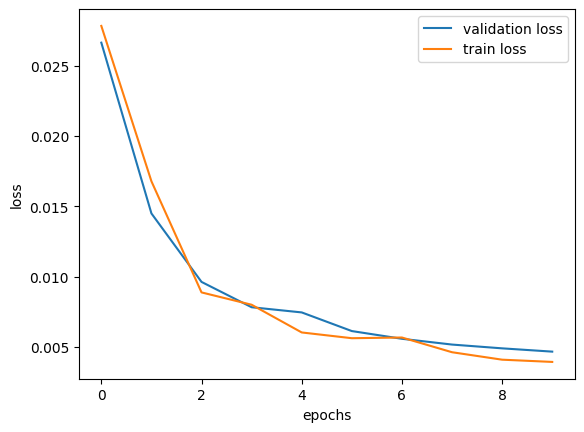

In [ ]:
plt.plot(metric_dict["val_loss"], label = "validation loss")
plt.plot(metric_dict["train_loss"], label = "train loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

In [ ]:
import pickle

with open(str(SAVE_DIR / 'metric_dict.pkl'), 'wb') as f:
    pickle.dump(metric_dict, f)

## Post training

In [ ]:
dataiter = iter(training_loader)
face, eye_left, eye_right, face_mask, y = next(dataiter)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

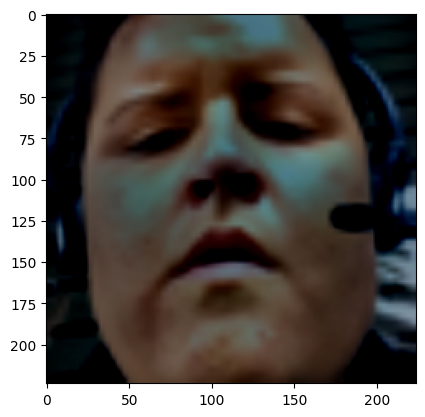

In [ ]:
index = 4
single_face, single_eye_left, single_eye_right, single_face_mask, single_y = face[index], eye_left[index], eye_right[index], face_mask[index], y[index]
# Create a grid from the images and show them
plt.imshow(np.transpose(single_face.numpy(), (1, 2, 0)))

In [ ]:
single_y

tensor([ 0.0000, -5.5859])

In [ ]:
model.eval()
faces, eyes_left, eyes_right, face_masks, labels = face, eye_left, eye_right, face_mask, y
# Send all tensors to device
faces, eyes_left, eyes_right, face_masks, labels = \
    faces.to(device),\
    eyes_left.to(device),\
    eyes_right.to(device),\
    face_masks.to(device),\
    labels.to(device)
voutputs = model(faces, eyes_left, eyes_right, face_masks)
voutputs[index]

tensor([-0.6885, -2.7392], device='cuda:0', grad_fn=<SelectBackward0>)

## Some More Post Training


In [ ]:
npzfile = np.load(dataset_file)
val_y = npzfile['val_y'].astype('float16')

In [ ]:
val_y.shape

(5000, 2)

In [ ]:
print(f"Min: {np.min(val_y, axis=0)}")
print(f"Max: {np.max(val_y, axis=0)}")
print(f"Mean: {np.mean(val_y, axis=0)}")
print(f"Mean: {np.mean(val_y, axis=0)}")

Min: [-20.25 -20.95]
Max: [20.25 20.25]
Mean: [-0.01024 -1.985  ]


In [ ]:
# Hyperparameters
device = torch.device("cuda:0")
num_workers = 2
pin_memory = True
batch_size = 1024

model = ITrackerModel().to(device)
model.load_state_dict(torch.load(SAVE_BEST_FILE))

<All keys matched successfully>

In [ ]:
validation_set = TestITrackerData(str(dataset_file))
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)

In [ ]:
label_list = np.array([[0,0]])
predicted_list = np.array([[0,0]])

model.eval()
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        print(f"Starting Batch {i+1}/{len(validation_loader)}")
        faces, eyes_left, eyes_right, face_masks, labels = vdata
        faces, eyes_left, eyes_right, face_masks, labels = \
            faces.to(device),\
            eyes_left.to(device),\
            eyes_right.to(device),\
            face_masks.to(device),\
            labels.to(device)
        print(labels.cpu().numpy().shape)
        print(label_list.shape)
        voutputs = model(faces, eyes_left, eyes_right, face_masks)
        label_list = np.append(label_list, labels.cpu().numpy(), axis=0)
        predicted_list = np.append(predicted_list, voutputs.cpu().numpy(), axis=0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Starting Batch 1/5
(1024, 2)
(1, 2)
Starting Batch 2/5
(1024, 2)
(1025, 2)
Starting Batch 3/5
(1024, 2)
(2049, 2)
Starting Batch 4/5
(1024, 2)
(3073, 2)
Starting Batch 5/5
(904, 2)
(4097, 2)


In [ ]:
label_list = label_list[1:]
predicted_list = predicted_list[1:]

In [ ]:
print(label_list.shape)
label_list

(5000, 2)


array([[ 1.70117188e+00, -1.93847656e+00],
       [-6.85156250e+00,  7.72949219e-01],
       [-1.08906250e+01,  5.00202179e-04],
       ...,
       [-7.52734375e+00,  9.69238281e-01],
       [ 5.78906250e+00, -4.60449219e-01],
       [-3.64257812e+00, -9.69238281e-01]])

In [ ]:
print(predicted_list.shape)
predicted_list

(5000, 2)


array([[ 1.89667797,  1.45209956],
       [-6.59438276,  1.59785092],
       [-7.71013403,  1.2538861 ],
       ...,
       [-8.12311554, -0.21466507],
       [ 5.07650423,  0.16453616],
       [-3.61734986,  0.44472036]])

In [ ]:
difference = np.subtract(predicted_list, label_list)

In [ ]:
from numpy import linalg
norm_diff = linalg.norm(difference, axis=1)
print("Stats for sample wise MSE on validation set")
print(f"Min: {np.min(norm_diff)}")
print(f"Max: {np.max(norm_diff)}")
print(f"Mean: {np.mean(norm_diff)}")
print(f"Std: {np.std(norm_diff)}")

Stats for sample wise MSE on validation set
Min: 0.01380352084197529
Max: 17.555279466350587
Mean: 2.4313320930575806
Std: 1.9196250507162032


In [ ]:
x_diff = difference[:,0]
y_diff = difference[:,1]

In [ ]:
H, xedges, yedges = np.histogram2d(x_diff, y_diff, bins=50)
H = H.T

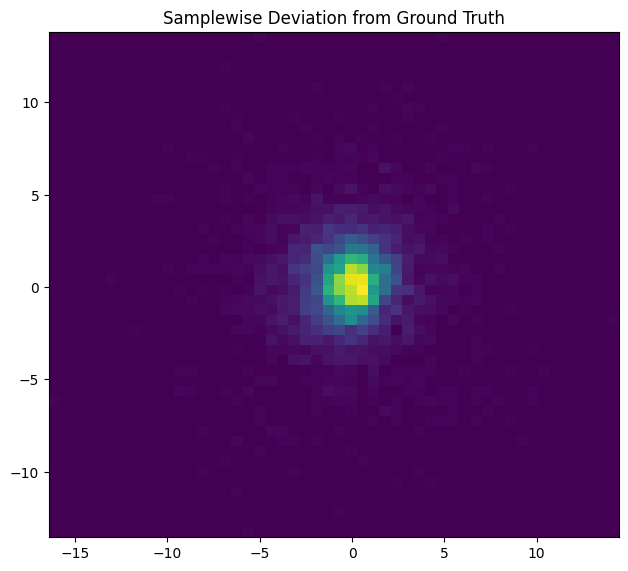

In [ ]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(132, title='Samplewise Deviation from Ground Truth',
        aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)